In [1]:
# The Sequential Model

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# when to use a sequential model: A Sequential Model is appropriate for a plain
# stack of layers where each layer has exactly one input tensor and one output tensor

# Define Sequential model with 3 layers
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, activation="relu", name="layer1"),
    tf.keras.layers.Dense(3, activation="relu", name="layer2"),
    tf.keras.layers.Dense(4, name="layer3")
])

# call model on a test input
x = tf.ones((3,3))
y = model(x)


In [3]:
'''
A sequential model is not appropriate when:
    1. your model has multiple inputs or multiple outputs
    2. Any of your layers has multiple inputs or multiple outputs
    3. You need to do layer sharing
    4. You want non-linear topology (e.g. a residual connection, a multi-branch model)

Note: There is also a corresponding pop() method to remove layers:
a sequential model behaves very much like a list of layers.

'''
print(model.layers)

[<tensorflow.python.keras.layers.core.Dense object at 0x7fc61b7325c0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc61a86ed68>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc61a86ea58>]


In [5]:
layer = layers.Dense(3)
layer.weights
# it create its weights the first time called on an input, since the shape of the
# weights depends on the shape of the inputs:

# call layer on a test input
x = tf.ones((1,4))
y = layer(x)
layer.weights

'''
Models built with a predefined input shape like this always have weights (even before
seeing any data) and always have a defined output shape.
'''

[<tf.Variable 'dense_1/kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.41573596,  0.59593153, -0.87636095],
        [ 0.7407646 , -0.09603465,  0.45464432],
        [ 0.79758275, -0.31994504,  0.17598164],
        [-0.16361725, -0.49288005, -0.8967176 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [6]:
'''
A common debugging workflow : add() + summary()

when building a new Sequential architecture, it is useful to incrementally stack layers
with add() and frequently print model summaries. For instance, this enables you to monitor
how a stack of Conv2D and MaxPooling2D layers is downsampling image feature maps.

'''
model = keras.Sequential()
model.add(keras.Input(shape=(250, 250, 3))) # 250*250 RGB images
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPool2D(3))

In [7]:
# Transfer learning with a Sequential model
'''
Transfer learning consists of freezing the bottom layers in a model and only training the top layers.

'''
model = keras.Sequential([
    keras.Input(shape=(784)),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(10),
])

# presumably you would want to first load pre-trained weights
model.load_weights(...)

# freeze all layers except the last one.
for layer in model.layers[:-1]:
    layer.trainable = False

# recompile and train the model ( this will only updates the weights of the last layer)
model.compile(...)
model.fit(...)


AttributeError: 'ellipsis' object has no attribute 'endswith'

In [8]:
# Transfer Learning and Fine-tuning

import numpy as np
import tensorflow as tf
from tensorflow import keras

layer = keras.layers.Dense(3)
layer.build((None, 4)) # create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print(len(layer.non_trainable_weights))


weights: 2
trainable_weights: 2
0


In [10]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # reserve 10% for validation and 10% for test
    split = ["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True, # include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /Users/rwang/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


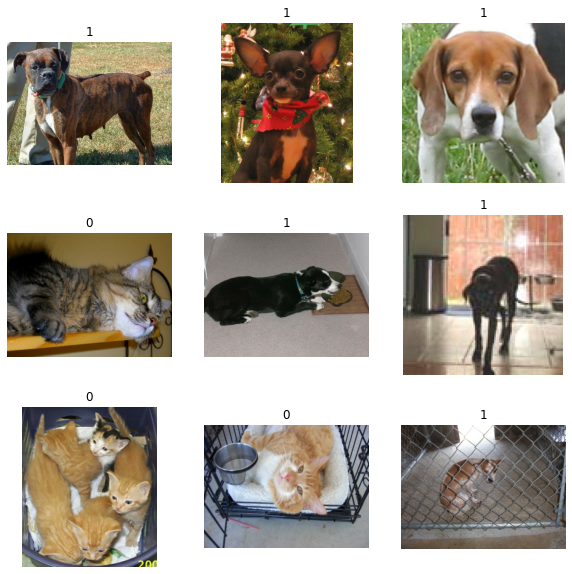

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [12]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

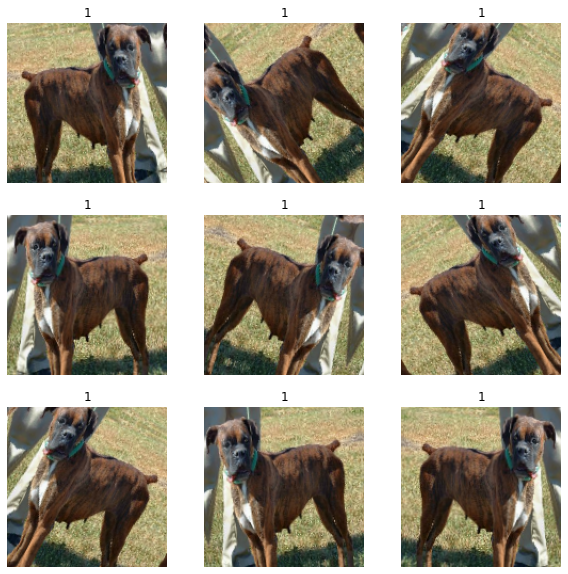

In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training = True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [15]:
# build a model
# we add a normalization layer to scale input values (initially in the [0, 255] range) to the
# [-1, 1] range
# we add a dropout layer before the classification layer, for regularization
# we make sure to pass training=False when calling the base model, so that it runs in inference model.
# so that batchnorm statistics do not get updated even after we unfreeze the base model for fine-tuning

based_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3), # do not include the ImageNet Classifier at the top
    include_top=False
)

# freeze the base model
based_model.trainable = False

# create a new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) # Apply random data augmentation

# pre-trained Xception weights requires that input be normalized
# from (0,255) to a range(-1, 1) the normalization layer
# does the following, outputs = (inputs - mean)/sqrt(var)

norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

# scale inputs to [-1, 1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# the base model contains batchnorm layers.
# we want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the basemodel is running
# in inference mode here.

x = based_model(x, training=False)
x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Dropout(0.2)(x) # regularize with dropout
#
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer = keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2049

KeyboardInterrupt: 

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)